In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sqlalchemy import create_engine

from modeling import model, sil_score

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Scoring functions

In [2]:
engine = create_engine('postgres://julia@localhost/affiled')

In [3]:
def score_clusts(model_results):
    return np.mean(model_results[0].loc[:100, 'sil_score'])

def score_phrase(phrase):
    left_results = model(phrase, 1, engine)
    right_results = model(phrase, -1, engine)
    
    if left_results is None or right_results is None:
        return None
    
    left_score = score_clusts(left_results)
    right_score = score_clusts(right_results)
    
    return np.mean([left_score, right_score]), left_score, right_score

def score_phrases(phrases):
    scores = []
    for phrase in tqdm(phrases): 
        score = score_phrase(phrase)
        scores.append(score)
        
    return scores

# Compute scores for sample phrases

In [4]:
phrases = [
    'trump',
    'hillary',
    'muslim',
    'taxes',
    'parenthood',
    'congress',
    'immigration',
    'student loans',
    'college',
    'police',
    'security',
    'abortion',
    'poverty',
    'bernie',
    'gun control',
    'oregon',
    'iowa',
    'black',
    'violence',
    'minimum wage',
    'isis',
    'jobs',
    'iran',
    'refugee',
    'terrorism',
    'healthcare'
]

In [5]:
my_scores = score_phrases(phrases)

In [6]:
overall, left, right = zip(*my_scores)
pd.Series(overall).describe()

count    26.000000
mean      0.236092
std       0.066833
min       0.129066
25%       0.195089
50%       0.222737
75%       0.256300
max       0.388586
dtype: float64

[]

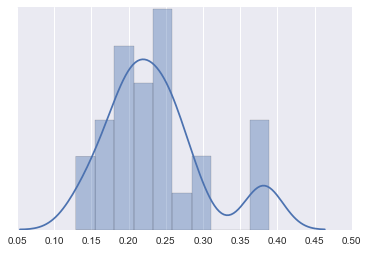

In [7]:
p=sns.distplot(overall, norm_hist=False, bins=10)
p.axes.get_yaxis().set_ticks([])

In [8]:
print pd.Series(left).describe()
print pd.Series(right).describe()

count    26.000000
mean      0.243909
std       0.111445
min       0.141276
25%       0.178900
50%       0.212979
75%       0.264421
max       0.584634
dtype: float64
count    26.000000
mean      0.228274
std       0.078959
min       0.082023
25%       0.192266
50%       0.216042
75%       0.245174
max       0.535793
dtype: float64


[]

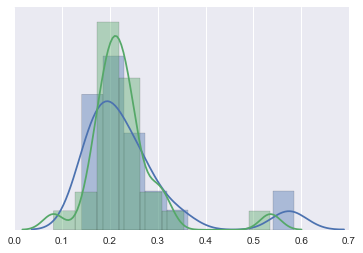

In [9]:
p=sns.distplot(left, norm_hist=False, bins=10)
sns.distplot(right, norm_hist=False, bins=10)
p.axes.get_yaxis().set_ticks([])

# Compare to random

In [15]:
def random_model(phrase, affil, smart=True):
    model_results = model(phrase, affil, engine, fit=False)
    
    if model_results is None:
        return None

    original_sims = model_results
    
    if smart:
        inds = range(original_sims.shape[0])
        np.random.shuffle(inds)
        
        keyword_inds = inds[:100]
        sims = original_sims[keyword_inds, :][:, keyword_inds]
    
        n = np.random.choice([10, 15, 20])
        
    else:
        sims = original_sims
        n = np.random.randint(2, sims.shape[0])
        
    labels = [np.random.choice(range(n)) for _ in range(sims.shape[0])]
    
    sil_scores = sil_score(sims, labels)
    
    return np.mean(sil_scores)

In [16]:
def randomly_score_phrases(phrases, smart, n_iters = 50):
    scores = []
    for phrase in tqdm(phrases):
        phrase_scores = []
        for _ in range(n_iters):
            phrase_scores.append(np.mean([random_model(phrase, affil, smart) 
                                             for affil in [-1, 1]]))
        scores.append(np.mean(phrase_scores))
    return scores

In [17]:
np.random.seed(5329505)
random_scores_stupid = randomly_score_phrases(phrases, False)  
random_scores_smart = randomly_score_phrases(phrases, True) 

In [47]:
pd.Series(random_scores_stupid).describe()

count    26.000000
mean     -0.584086
std       0.078550
min      -0.708895
25%      -0.623661
50%      -0.601384
75%      -0.542234
max      -0.402421
dtype: float64

In [48]:
pd.Series(random_scores_smart).describe()

count    26.000000
mean     -0.508473
std       0.092489
min      -0.684002
25%      -0.557316
50%      -0.526301
75%      -0.452630
max      -0.299692
dtype: float64

[]

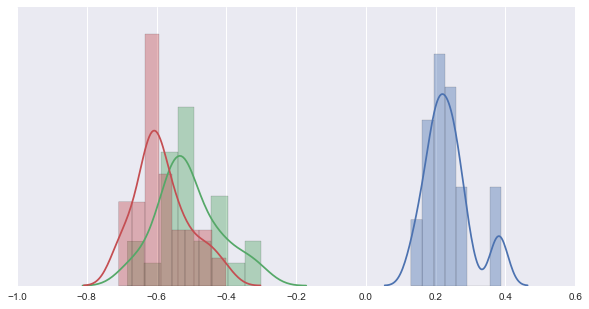

In [37]:
plt.figure(1, figsize = (10, 5))
p=sns.distplot(my_scores, bins=8)
sns.distplot(random_scores_smart, bins=8)
sns.distplot(random_scores_stupid, bins=8)
p.axes.get_yaxis().set_ticks([])